# Multitask learning for Structure – Activity relationship: a tutorial for toxicological applications

##### Cecile Valsecchi, ...

## Table of Contents
1. [Preliminary steps](#prel)
2. [Data Analysis](#data)
3. [Single task models](#stl)
    1. [Architecture](#stl_arch) 
    2. [Models](#stl_mod) 
4. [Multi task model](#mtl)
    1. [Architecture](#mtl_arch)
    2. [Model](#mtl_mod)
5. [Comparison](#comp)

## 1. Preliminary steps <a name="prel"></a>

In the following lines, we add the necessary repo folders to the path. Do not delete these lines if you want the notebook to work. However, you can import additional packages you might need.

In [1]:
# adds the paths to the repo folder
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy
from utils import *
%load_ext autoreload
%autoreload 2

## 2. Data analysis <a name="data"></a>

In [2]:
#import dataset
data_train = pd.read_csv("./data/Xtrain_nura.csv")
data_test = pd.read_csv("./data/Xtest_nura.csv")
data_train.head()

,ID,SMILES,SOURCES,AGO_PR,ANT_PR,BIN_PR,AGO_PXR,BIN_PXR,AGO_RXR,BIN_RXR,...,bit1015,bit1016,bit1017,bit1018,bit1019,bit1020,bit1021,bit1022,bit1023,bit1024
0,2420,CCC12CCC(=O)C(=C2c2c(C1)cc(cc2)O)Br,NR-DBIND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,729,CC(=Cc1ccc(s1)C(=O)O)c1ccc2c(c1)C(C)(C)CCC2(C)C,ChEMBL,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,0,0,1,0,0,0,0,0,0,0
2,6562,COc1ccc(cc1F)c1cc(nn1c1ccc(cc1)S(=O)(=O)N)C(F)F,Tox21,0.0,NaN,0.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,10751,O=C(Nc1ccc(c(c1)Cl)Cl)Nc1ccc(cc1)Cl,Tox21,0.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,1,0,0,0,0,0
4,13780,Oc1cc(C)c2c(c1)c(=O)oc1c2ccc(c1C)O,NR-DBIND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1


In [3]:
tasks = data_train.columns[3:33]
tasks

Index(['AGO_PR', 'ANT_PR', 'BIN_PR', 'AGO_PXR', 'BIN_PXR', 'AGO_RXR',
       'BIN_RXR', 'AGO_GR', 'ANT_GR', 'BIN_GR', 'AGO_AR', 'ANT_AR', 'BIN_AR',
       'AGO_ERA', 'ANT_ERA', 'BIN_ERA', 'AGO_ERB', 'ANT_ERB', 'BIN_ERB',
       'AGO_FXR', 'ANT_FXR', 'BIN_FXR', 'AGO_PPARD', 'ANT_PPARD', 'BIN_PPARD',
       'AGO_PPARG', 'ANT_PPARG', 'BIN_PPARG', 'AGO_PPARA', 'BIN_PPARA'],
      dtype='object')

In [4]:
data_train_fps = data_train.loc[:,[f"bit{i}" for i in range(1,1025)]]
data_test_fps = data_test.loc[:,[f"bit{i}" for i in range(1,1025)]]
data_train_fps.head()

,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,bit10,...,bit1015,bit1016,bit1017,bit1018,bit1019,bit1020,bit1021,bit1022,bit1023,bit1024
0,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [5]:
data_train_tasks = data_train.loc[:,tasks]
data_test_tasks = data_test.loc[:,tasks]
data_train_tasks.head()

,AGO_PR,ANT_PR,BIN_PR,AGO_PXR,BIN_PXR,AGO_RXR,BIN_RXR,AGO_GR,ANT_GR,BIN_GR,...,ANT_FXR,BIN_FXR,AGO_PPARD,ANT_PPARD,BIN_PPARD,AGO_PPARG,ANT_PPARG,BIN_PPARG,AGO_PPARA,BIN_PPARA
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', n_iter=5000, metric = 'jaccard', square_distances = True).fit_transform(data_train_fps.values)

C:\Users\Workstation\Anaconda3\envs\chaptenv\lib\site-packages\sklearn\metrics\pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
C:\Users\Workstation\Anaconda3\envs\chaptenv\lib\site-packages\sklearn\metrics\pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


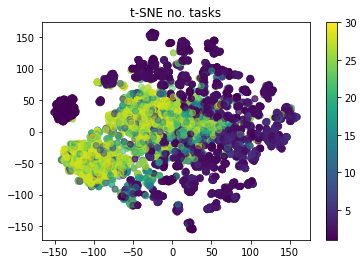

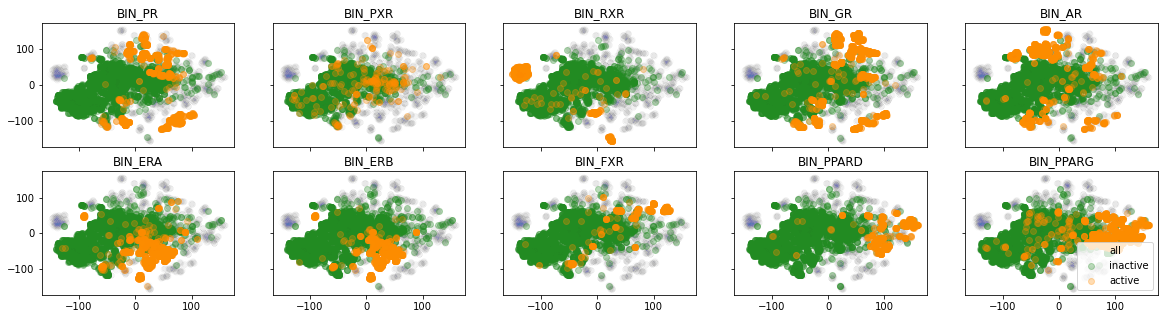

In [7]:
bin_tasks = [i for i in tasks if "BIN" in i]

fig, ax = plt.subplots()
pcm = ax.scatter(X_embedded[:,0],X_embedded[:,1], c=np.sum(~np.isnan(data_train_tasks.values), axis = 1), alpha = 0.5)
ax.set_title("t-SNE no. tasks")
color_bar = fig.colorbar(pcm,ax = ax)
color_bar.set_alpha(1)
color_bar.draw_all()
#fig.colorbar(pcm, ax=axs[0, 0])

plt.savefig("TSNE1.svg")

fig, axs = plt.subplots(2, 5, figsize = (20,5))
cnt = 0
for r,c in [(0,0),(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(1,4)]:
    axs[r,c].scatter(X_embedded[:,0],
                     X_embedded[:,1], 
                     alpha = 0.005)
    axs[r,c].scatter(X_embedded[data_train_tasks[bin_tasks[cnt]].values==0,0],
                     X_embedded[data_train_tasks[bin_tasks[cnt]].values==0,1], 
                     color = 'forestgreen',
                     alpha = 0.3)
    axs[r,c].scatter(X_embedded[data_train_tasks[bin_tasks[cnt]].values==1,0],
                     X_embedded[data_train_tasks[bin_tasks[cnt]].values==1,1], 
                     color = 'darkorange',
                     alpha = 0.3)
    axs[r,c].set_title(bin_tasks[cnt])
    
    if (r,c) == (1,4):
        leg = axs[r,c].legend(["all", "inactive", "active"])    
    cnt += 1

for ax in axs.flat:
    ax.label_outer()

plt.savefig("TSNE2.svg")
plt.show()


In [8]:
header = pd.MultiIndex.from_product([['TRAINING SET','TEST SET'],
                                     ['#active','%active','#inactive','%inactive','#missing']])
pd.DataFrame(np.array([np.sum(data_train_tasks.values == 1, axis = 0),
                   np.round((np.sum(data_train_tasks.values == 1, axis = 0)/np.sum(~np.isnan(data_train_tasks.values), axis = 0))*100,1), 
                   np.sum(data_train_tasks.values == 0, axis = 0),
                   np.round((np.sum(data_train_tasks.values == 0, axis = 0)/np.sum(~np.isnan(data_train_tasks.values), axis = 0))*100,1),
                   np.sum(np.isnan(data_train_tasks.values), axis = 0),
                   np.sum(data_test_tasks.values == 1, axis = 0),
                   np.round((np.sum(data_test_tasks.values == 1, axis = 0)/np.sum(~np.isnan(data_test_tasks.values), axis = 0))*100,1), 
                   np.sum(data_test_tasks.values == 0, axis = 0),
                   np.round((np.sum(data_test_tasks.values == 0, axis = 0)/np.sum(~np.isnan(data_test_tasks.values), axis = 0))*100,1),
                   np.sum(np.isnan(data_test_tasks.values), axis = 0)]).T,
                  index=tasks, 
                  columns=header)

TRAINING SET                                      TEST SET          \
               #active %active #inactive %inactive #missing  #active %active   
AGO_PR           291.0     6.1    4508.0      93.9   7171.0     58.0     4.8   
ANT_PR           586.0    14.3    3513.0      85.7   7871.0    155.0    14.9   
BIN_PR          1008.0    20.0    4021.0      80.0   6941.0    243.0    19.3   
AGO_PXR          187.0     5.7    3073.0      94.3   8710.0     41.0     4.9   
BIN_PXR          191.0     5.9    3073.0      94.1   8706.0     42.0     5.0   
AGO_RXR          104.0     2.8    3634.0      97.2   8232.0     26.0     2.8   
BIN_RXR          703.0    16.2    3649.0      83.8   7618.0    158.0    14.7   
AGO_GR           586.0    12.0    4293.0      88.0   7091.0    151.0    12.2   
ANT_GR           518.0    12.4    3655.0      87.6   7797.0    139.0    13.1   
BIN_GR          1461.0    25.9    4183.0      74.1   6326.0    354.0    25.3   
AGO_AR           409.0     8.4    4452.0      91.6   7109.0    104.0     8.5   
ANT_AR           615.0    13.5    3951.0      86.5   7404.0    161.0    14.0   
BIN_AR          1113.0    21.3    4108.0      78.7   6749.0    306.0    23.0   
AGO_ERA          370.0     8.4    4050.0      91.6   7550.0    106.0     9.5   
ANT_ERA          275.0     6.2    4130.0      93.8   7565.0     87.0     7.8   
BIN_ERA         1031.0    20.9    3896.0      79.1   7043.0    256.0    21.0   
AGO_ERB          226.0     4.7    4588.0      95.3   7156.0     60.0     4.9   
ANT_ERB          179.0     4.2    4112.0      95.8   7679.0     45.0     4.2   
BIN_ERB          927.0    17.3    4443.0      82.7   6600.0    232.0    17.3   
AGO_FXR          293.0     6.4    4258.0      93.6   7419.0     79.0     6.8   
ANT_FXR           96.0     2.4    3843.0      97.6   8031.0     28.0     2.8   
BIN_FXR          432.0     9.3    4195.0      90.7   7343.0    118.0     9.9   
AGO_PPARD        485.0     9.7    4520.0      90.3   6965.0    131.0    10.3   
ANT_PPARD         21.0     0.5    4442.0      99.5   7507.0      7.0     0.6   
BIN_PPARD        578.0    11.2    4587.0      88.8   6805.0    152.0    11.6   
AGO_PPARG       1094.0    20.7    4182.0      79.3   6694.0    258.0    19.9   
ANT_PPARG         66.0     1.5    4195.0      98.5   7709.0     22.0     2.0   
BIN_PPARG       1363.0    23.8    4356.0      76.2   6251.0    336.0    23.4   
AGO_PPARA        796.0    98.5      12.0       1.5  11162.0    202.0    99.0   
BIN_PPARA        979.0    98.8      12.0       1.2  10979.0    241.0    98.8   

                                        
          #inactive %inactive #missing  
AGO_PR       1162.0      95.2   1773.0  
ANT_PR        887.0      85.1   1951.0  
BIN_PR       1019.0      80.7   1731.0  
AGO_PXR       793.0      95.1   2159.0  
BIN_PXR       793.0      95.0   2158.0  
AGO_RXR       915.0      97.2   2052.0  
BIN_RXR       920.0      85.3   1915.0  
AGO_GR       1091.0      87.8   1751.0  
ANT_GR        922.0      86.9   1932.0  
BIN_GR       1045.0      74.7   1594.0  
AGO_AR       1126.0      91.5   1763.0  
ANT_AR        991.0      86.0   1841.0  
BIN_AR       1022.0      77.0   1665.0  
AGO_ERA      1010.0      90.5   1877.0  
ANT_ERA      1030.0      92.2   1876.0  
BIN_ERA       965.0      79.0   1772.0  
AGO_ERB      1156.0      95.1   1777.0  
ANT_ERB      1021.0      95.8   1927.0  
BIN_ERB      1111.0      82.7   1650.0  
AGO_FXR      1091.0      93.2   1823.0  
ANT_FXR       986.0      97.2   1979.0  
BIN_FXR      1077.0      90.1   1798.0  
AGO_PPARD    1143.0      89.7   1719.0  
ANT_PPARD    1119.0      99.4   1867.0  
BIN_PPARD    1155.0      88.4   1686.0  
AGO_PPARG    1041.0      80.1   1694.0  
ANT_PPARG    1054.0      98.0   1917.0  
BIN_PPARG    1102.0      76.6   1555.0  
AGO_PPARA       2.0       1.0   2789.0  
BIN_PPARA       3.0       1.2   2749.0

In [9]:
X_train, y_train, X_test, y_test = prepare_data(data_train, 
                                                data_test,
                                                [f"bit{i}" for i in range(1,1025)],
                                                tasks)

In [10]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((11970, 1024), (11970, 30), (2993, 1024), (2993, 30))

In [19]:
mod = "BIN"

y_train_copy = y_train.copy()
y_train_copy[y_train_copy == -1] = np.nan
a = pdist(y_train_copy.T, "matching")
df = pd.DataFrame(squareform(a), index = tasks, columns = tasks)
df = df.loc[[i for i in list(df.columns) if mod in i],[i for i in list(df.columns) if mod in i]]
df.style.background_gradient(cmap='Blues')

,BIN_PR,BIN_PXR,BIN_RXR,BIN_GR,BIN_AR,BIN_ERA,BIN_ERB,BIN_FXR,BIN_PPARD,BIN_PPARG,BIN_PPARA
BIN_PR,0.000000,0.750710,0.726650,0.679866,0.700835,0.731078,0.704929,0.692481,0.704261,0.717711,0.999916
BIN_PXR,0.750710,0.000000,0.772013,0.775272,0.779950,0.787302,0.773434,0.759231,0.771596,0.776942,0.999916
BIN_RXR,0.726650,0.772013,0.000000,0.743191,0.751963,0.763576,0.738262,0.719382,0.729574,0.739933,0.999916
BIN_GR,0.679866,0.775272,0.743191,0.000000,0.663074,0.697911,0.664495,0.694653,0.655388,0.672097,0.999916
BIN_AR,0.700835,0.779950,0.751963,0.663074,0.000000,0.702005,0.668922,0.702423,0.664996,0.680201,0.999916
BIN_ERA,0.731078,0.787302,0.763576,0.697911,0.702005,0.000000,0.618129,0.718964,0.685213,0.697661,0.999916
BIN_ERB,0.704929,0.773434,0.738262,0.664495,0.668922,0.618129,0.000000,0.685631,0.637845,0.655138,0.999916
BIN_FXR,0.692481,0.759231,0.719382,0.694653,0.702423,0.718964,0.685631,0.000000,0.674854,0.693484,0.999916
BIN_PPARD,0.704261,0.771596,0.729574,0.655388,0.664996,0.685213,0.637845,0.674854,0.000000,0.618797,0.970426
BIN_PPARG,0.717711,0.776942,0.739933,0.672097,0.680201,0.697661,0.655138,0.693484,0.618797,0.000000,0.935589


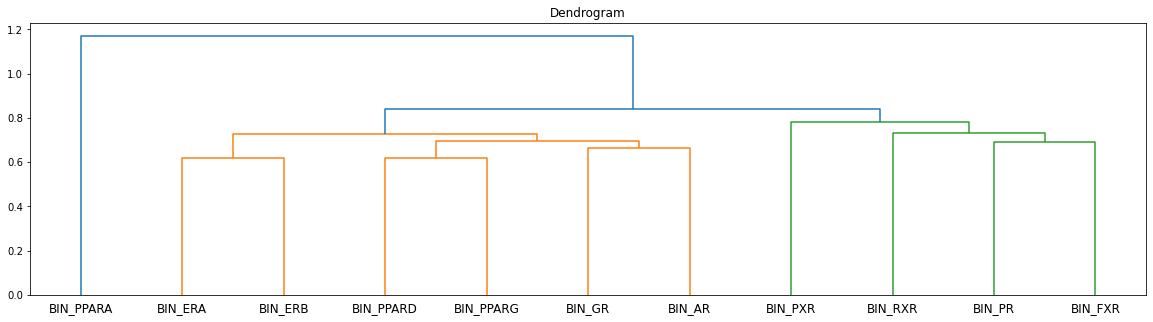

In [25]:
idx = []
for i in tasks:
    if mod in i:
        idx.append(True)
    else:
        idx.append(False)
y_train_copy_red = y_train_copy[:,idx]

a = pdist(y_train_copy_red.T, "matching")
Z = hierarchy.linkage(a, 'ward')
plt.figure(figsize = (20,5))
plt.title("Dendrogram")
dn = hierarchy.dendrogram(Z, labels= [i for i in tasks if mod in i])
plt.savefig("dendrogram.svg")

## 3. Single task models <a name="stl_arch"></a>

### 3.1 Architecture <a name="stl_arch"></a>

In [38]:
Set_stl = Settings(data_train = data_train,
                   data_test = data_test,
                   labelX = [f"bit{i}" for i in range(1,1025)],
                   labelY = tasks,
                   tasks = tasks,
                   layers = [100,100],
                   act_fnc = 'relu',
                   epochs = 1000,
                   batch_size = 10,
                   lr = 0.001,
                   opt = 'adam',
                   drp = 0.25)

### 3.2 Models <a name="stl_mod"></a>

In [39]:
def create_stl_model(X_train, Set):
    optim = do_opt(Set.opt, Set.lr)        
    inp = Input(shape=(X_train.shape[1],))
    hid = inp
    for l in Set.layers:
        hid = Dense(l, activation=Set.act_fnc, kernel_regularizer=keras.regularizers.L2(0.01))(hid)
        hid = Dropout(Set.drp)(hid)
    out = Dense(1, activation='sigmoid', name = "preds")(hid)

    model = keras.Model(inputs=inp, outputs=out)
    model.compile(loss=K.binary_crossentropy, optimizer=optim, metrics=["accuracy"])
    model.summary()
    return model

In [40]:
i = 4

X_train_i = X_train[y_train[:,i]!=MASK_VALUE,:]
y_train_i = y_train[y_train[:,i]!=MASK_VALUE,i]
X_test_i = X_test[y_test[:,i]!=MASK_VALUE,:]
y_test_i = y_test[y_test[:,i]!=MASK_VALUE,i]

print(f" TASK = {tasks[i]}")
print(f" No samples TRAIN = {len(X_train_i)}, No samples TEST =  {len(X_test_i)}")
print(f" % actives TRAIN = {np.round((np.sum(y_train_i==1)/len(y_train_i))*100,2)}, % actives TEST = {np.round((np.sum(y_test_i==1)/len(y_test_i))*100,2)}")

 TASK = BIN_PXR
 No samples TRAIN = 3264, No samples TEST =  835
 % actives TRAIN = 5.85, % actives TEST = 5.03


In [41]:
model = create_stl_model(X_train_i, Set_stl)

Model: "model_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_32 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_32 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_33 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)                 101       
Total params: 112,701
Trainable params: 112,701
Non-trainable params: 0
____________________________________________________

In [42]:
n_x = X_train_i.shape[0]
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(X_train_i, y_train_i, epochs=Set_stl.epochs, 
                    batch_size=int(Set_stl.batch_size*n_x/100),
                    callbacks=[es], verbose=1,
                    validation_data=(X_test_i, y_test_i))

Epoch 1/1000
11/11 [==============================] - 1s 29ms/step - loss: 2.9476 - accuracy: 0.8980 - val_loss: 2.4292 - val_accuracy: 0.9497
Epoch 2/1000
11/11 [==============================] - 0s 10ms/step - loss: 2.1860 - accuracy: 0.9415 - val_loss: 1.8293 - val_accuracy: 0.9497
Epoch 3/1000
11/11 [==============================] - 0s 9ms/step - loss: 1.6479 - accuracy: 0.9415 - val_loss: 1.4018 - val_accuracy: 0.9497
Epoch 4/1000
11/11 [==============================] - 0s 10ms/step - loss: 1.2707 - accuracy: 0.9415 - val_loss: 1.1021 - val_accuracy: 0.9497
Epoch 5/1000
11/11 [==============================] - 0s 10ms/step - loss: 1.0008 - accuracy: 0.9415 - val_loss: 0.8917 - val_accuracy: 0.9497
Epoch 6/1000
11/11 [==============================] - 0s 11ms/step - loss: 0.8128 - accuracy: 0.9415 - val_loss: 0.7437 - val_accuracy: 0.9497
Epoch 7/1000
11/11 [==============================] - 0s 10ms/step - loss: 0.6774 - accuracy: 0.9421 - val_loss: 0.6367 - val_accuracy: 0.9497


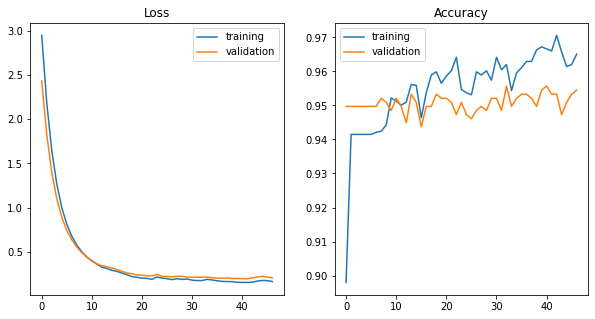

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(["training", "validation"])
ax1.set_title("Loss")
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(["training", "validation"])
ax2.set_title("Accuracy")

plt.show()

In [44]:
y_pred_val = model.predict(X_test_i)
y_pred_val = y_pred_val.flatten()

In [45]:
thr = calc_optimal_thr(y_pred_val[:,np.newaxis], y_test_i[:,np.newaxis])
print(f"optimal threshold = {thr[0]}")

optimal threshold = 0.05


In [46]:
preds_i = (y_pred_val>thr[0]*np.ones(y_test_i.shape))*1
sn, sp, ner = calc_class_param_mat(preds_i, np.array(y_test_i))
print(f"Sensitivity = {np.round(sn*100,2)}%")
print(f"Specificity = {np.round(sp*100,2)}%")
print(f"Non-Error-Rate = {np.round(ner*100,2)}%")

Sensitivity = 80.95%
Specificity = 82.35%
Non-Error-Rate = 81.65%


In [47]:
# REPEAT FOR ALL TASKS

 TASK = AGO_PR
 No samples TRAIN = 4799, No samples TEST =  1220
 % actives TRAIN = 6.06, % actives TEST = 4.75
Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_34 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_35 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)                 101       
Total params

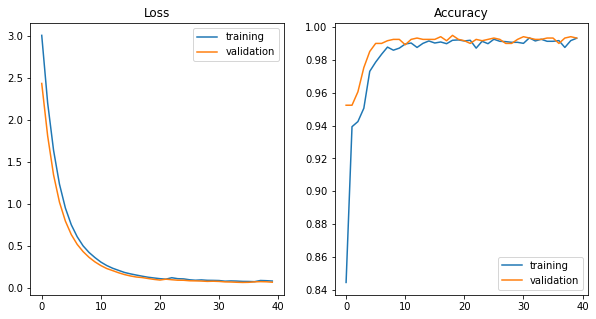

optimal threshold = 0.16
 TASK = ANT_PR
 No samples TRAIN = 4099, No samples TEST =  1042
 % actives TRAIN = 14.3, % actives TEST = 14.88
Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_36 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_36 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_37 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)              

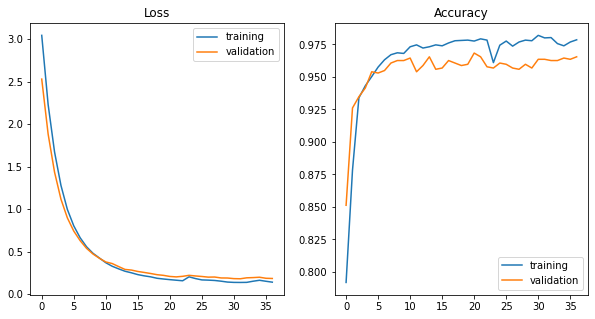

optimal threshold = 0.19
 TASK = BIN_PR
 No samples TRAIN = 5029, No samples TEST =  1262
 % actives TRAIN = 20.04, % actives TEST = 19.26
Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_38 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_38 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_39 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)             

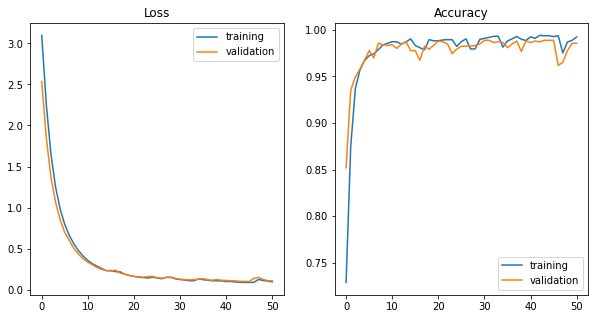

optimal threshold = 0.19
 TASK = AGO_PXR
 No samples TRAIN = 3260, No samples TEST =  834
 % actives TRAIN = 5.74, % actives TEST = 4.92
Model: "model_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_40 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_40 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_41 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)               

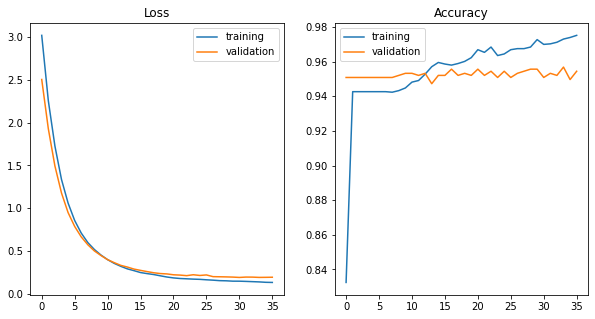

optimal threshold = 0.03
 TASK = BIN_PXR
 No samples TRAIN = 3264, No samples TEST =  835
 % actives TRAIN = 5.85, % actives TEST = 5.03
Model: "model_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_38 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_42 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_42 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_43 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)               

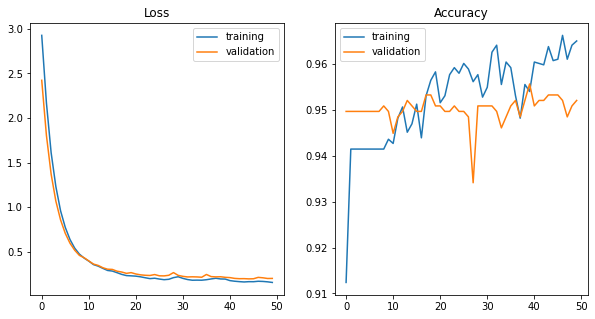

optimal threshold = 0.03
 TASK = AGO_RXR
 No samples TRAIN = 3738, No samples TEST =  941
 % actives TRAIN = 2.78, % actives TEST = 2.76
Model: "model_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_44 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_44 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_45 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)               

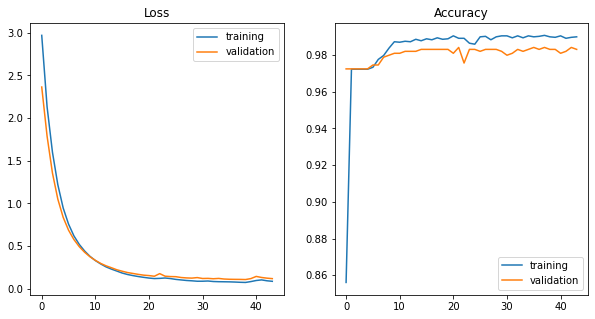

optimal threshold = 0.01
 TASK = BIN_RXR
 No samples TRAIN = 4352, No samples TEST =  1078
 % actives TRAIN = 16.15, % actives TEST = 14.66
Model: "model_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_46 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_46 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_47 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)            

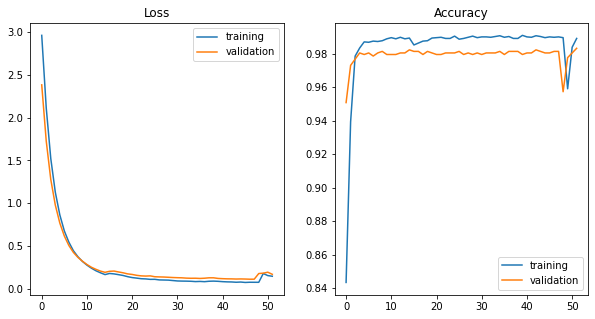

optimal threshold = 0.03
 TASK = AGO_GR
 No samples TRAIN = 4879, No samples TEST =  1242
 % actives TRAIN = 12.01, % actives TEST = 12.16
Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_48 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_48 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_49 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)             

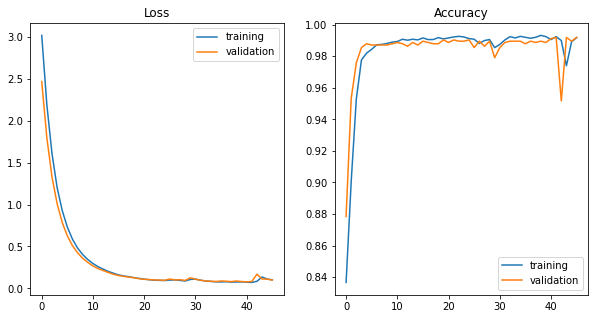

optimal threshold = 0.04
 TASK = ANT_GR
 No samples TRAIN = 4173, No samples TEST =  1061
 % actives TRAIN = 12.41, % actives TEST = 13.1
Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_50 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_50 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_51 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)              

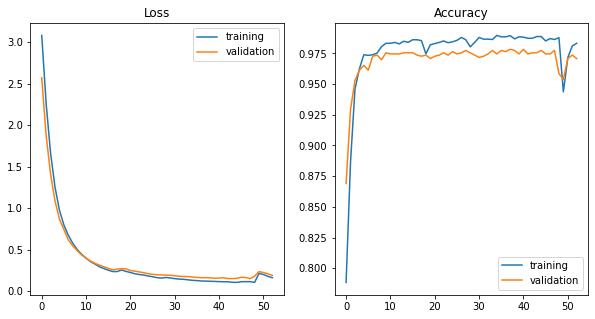

optimal threshold = 0.05
 TASK = BIN_GR
 No samples TRAIN = 5644, No samples TEST =  1399
 % actives TRAIN = 25.89, % actives TEST = 25.3
Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_52 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_52 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_53 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)              

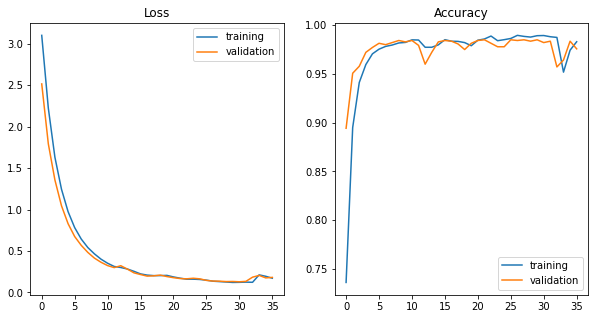

optimal threshold = 0.39
 TASK = AGO_AR
 No samples TRAIN = 4861, No samples TEST =  1230
 % actives TRAIN = 8.41, % actives TEST = 8.46
Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_54 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_54 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_55 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)               

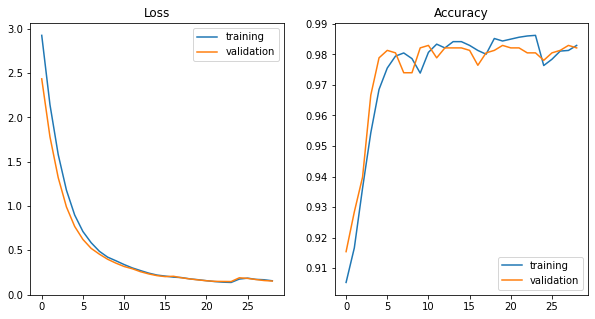

optimal threshold = 0.06
 TASK = ANT_AR
 No samples TRAIN = 4566, No samples TEST =  1152
 % actives TRAIN = 13.47, % actives TEST = 13.98
Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_56 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_56 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_57 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_57 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)             

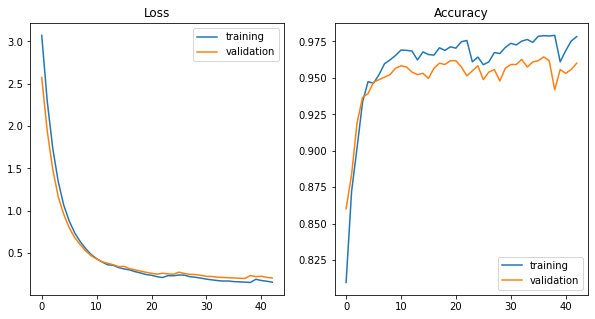

optimal threshold = 0.09
 TASK = BIN_AR
 No samples TRAIN = 5221, No samples TEST =  1328
 % actives TRAIN = 21.32, % actives TEST = 23.04
Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_58 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_58 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_59 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)             

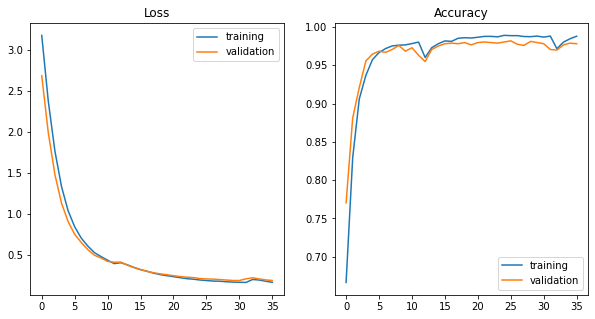

optimal threshold = 0.14
 TASK = AGO_ERA
 No samples TRAIN = 4420, No samples TEST =  1116
 % actives TRAIN = 8.37, % actives TEST = 9.5
Model: "model_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_60 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_60 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_61 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_61 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)               

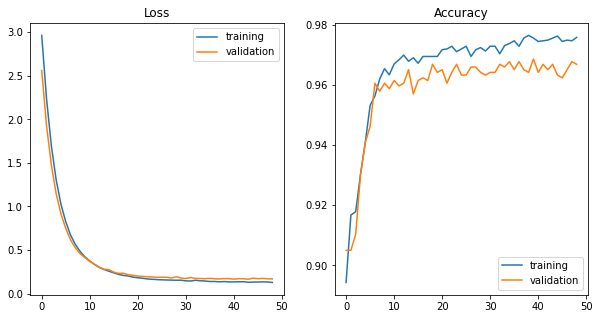

optimal threshold = 0.05
 TASK = ANT_ERA
 No samples TRAIN = 4405, No samples TEST =  1117
 % actives TRAIN = 6.24, % actives TEST = 7.79
Model: "model_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_48 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_62 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_62 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_63 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)              

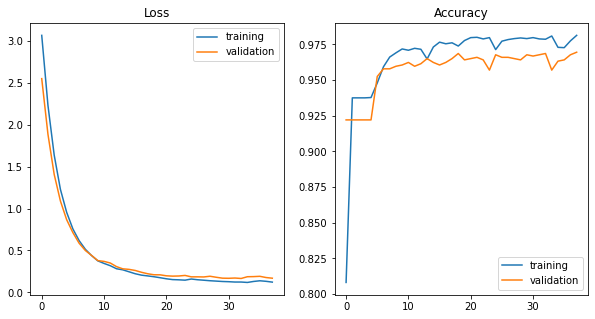

optimal threshold = 0.04
 TASK = BIN_ERA
 No samples TRAIN = 4927, No samples TEST =  1221
 % actives TRAIN = 20.93, % actives TEST = 20.97
Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_64 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_64 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_65 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)            

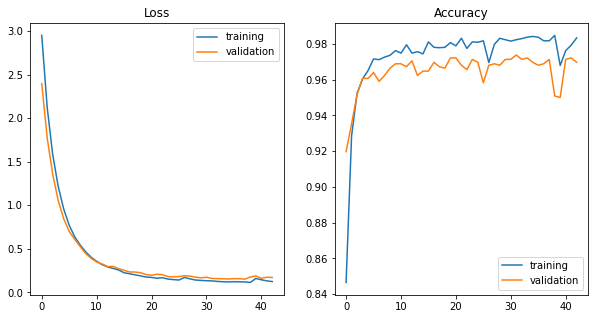

optimal threshold = 0.04
 TASK = AGO_ERB
 No samples TRAIN = 4814, No samples TEST =  1216
 % actives TRAIN = 4.69, % actives TEST = 4.93
Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_66 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_66 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_67 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)              

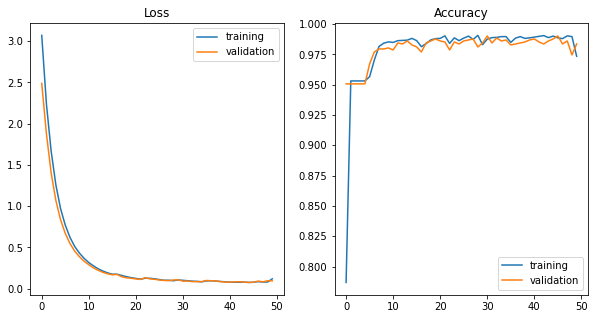

optimal threshold = 0.05
 TASK = ANT_ERB
 No samples TRAIN = 4291, No samples TEST =  1066
 % actives TRAIN = 4.17, % actives TEST = 4.22
Model: "model_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_68 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_68 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_69 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)              

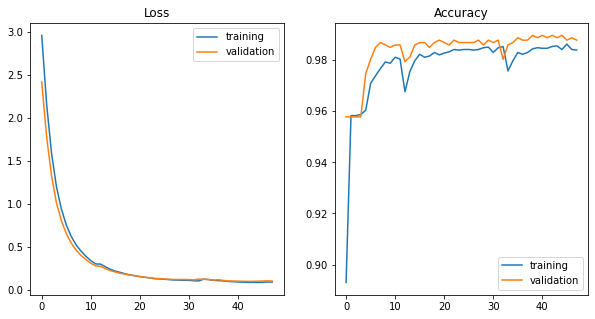

optimal threshold = 0.02
 TASK = BIN_ERB
 No samples TRAIN = 5370, No samples TEST =  1343
 % actives TRAIN = 17.26, % actives TEST = 17.27
Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_70 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_70 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_71 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)            

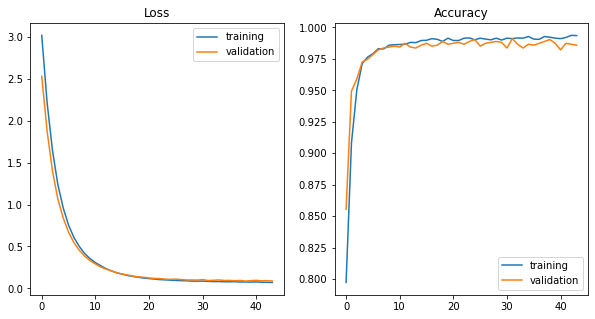

optimal threshold = 0.26
 TASK = AGO_FXR
 No samples TRAIN = 4551, No samples TEST =  1170
 % actives TRAIN = 6.44, % actives TEST = 6.75
Model: "model_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_72 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_72 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_73 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)              

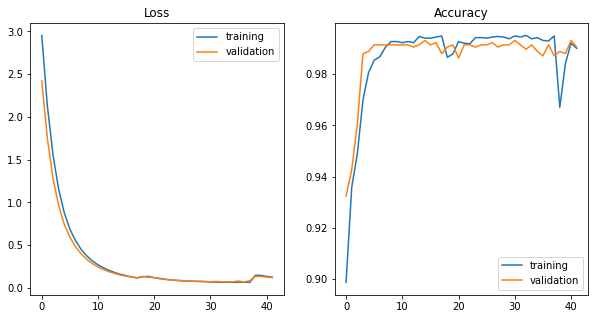

optimal threshold = 0.03
 TASK = ANT_FXR
 No samples TRAIN = 3939, No samples TEST =  1014
 % actives TRAIN = 2.44, % actives TEST = 2.76
Model: "model_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_54 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_74 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_74 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_75 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)              

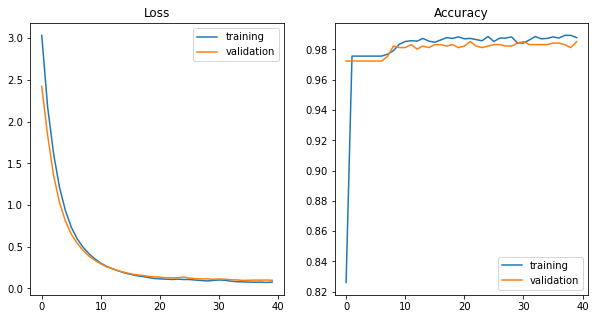

optimal threshold = 0.02
 TASK = BIN_FXR
 No samples TRAIN = 4627, No samples TEST =  1195
 % actives TRAIN = 9.34, % actives TEST = 9.87
Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_76 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_76 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_77 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)              

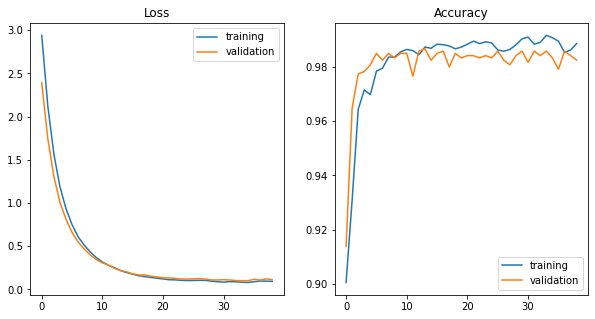

optimal threshold = 0.03
 TASK = AGO_PPARD
 No samples TRAIN = 5005, No samples TEST =  1274
 % actives TRAIN = 9.69, % actives TEST = 10.28
Model: "model_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_56 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_78 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_78 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_79 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)           

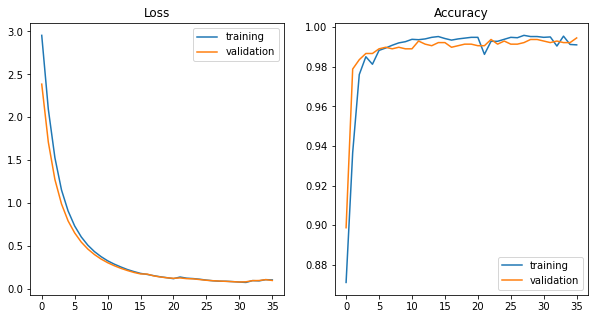

optimal threshold = 0.08
 TASK = ANT_PPARD
 No samples TRAIN = 4463, No samples TEST =  1126
 % actives TRAIN = 0.47, % actives TEST = 0.62
Model: "model_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_80 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_80 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_81 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_81 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)            

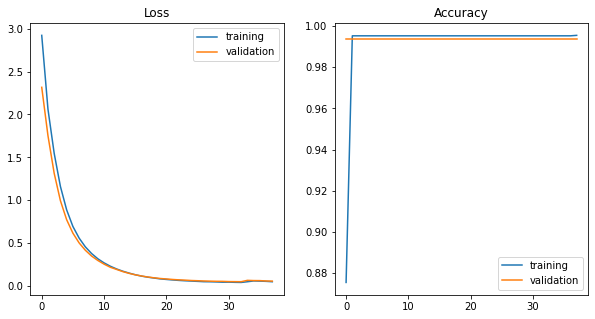

optimal threshold = 0.01
 TASK = BIN_PPARD
 No samples TRAIN = 5165, No samples TEST =  1307
 % actives TRAIN = 11.19, % actives TEST = 11.63
Model: "model_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_82 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_82 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_83 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_83 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)          

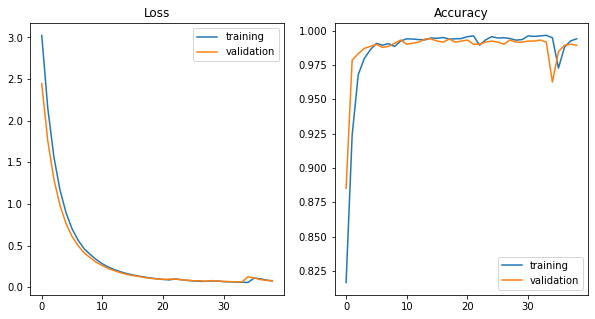

optimal threshold = 0.03
 TASK = AGO_PPARG
 No samples TRAIN = 5276, No samples TEST =  1299
 % actives TRAIN = 20.74, % actives TEST = 19.86
Model: "model_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_84 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_84 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_85 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)          

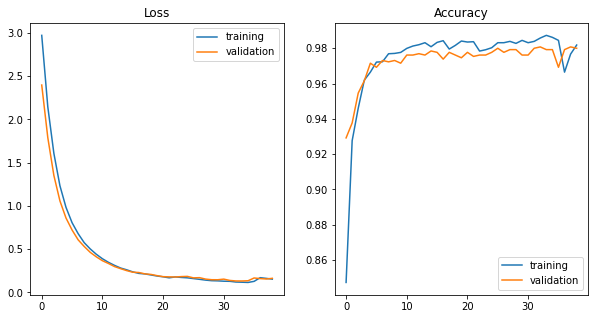

optimal threshold = 0.1
 TASK = ANT_PPARG
 No samples TRAIN = 4261, No samples TEST =  1076
 % actives TRAIN = 1.55, % actives TEST = 2.04
Model: "model_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_60 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_86 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_86 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_87 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)             

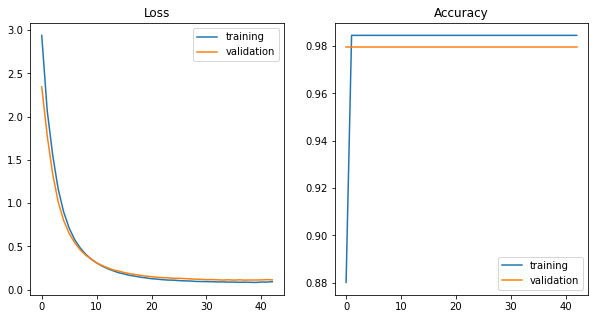

optimal threshold = 0.02
 TASK = BIN_PPARG
 No samples TRAIN = 5719, No samples TEST =  1438
 % actives TRAIN = 23.83, % actives TEST = 23.37
Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_61 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_88 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_88 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_89 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)          

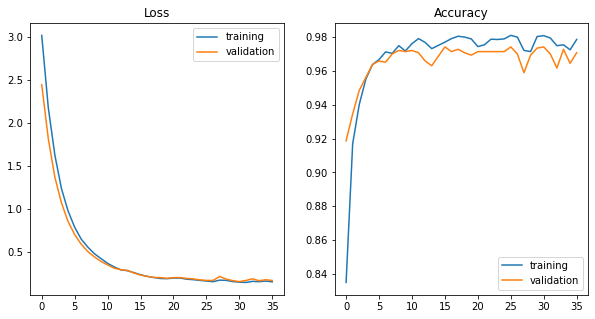

optimal threshold = 0.22
 TASK = AGO_PPARA
 No samples TRAIN = 808, No samples TEST =  204
 % actives TRAIN = 98.51, % actives TEST = 99.02
Model: "model_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_62 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_90 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_90 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_91 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)            

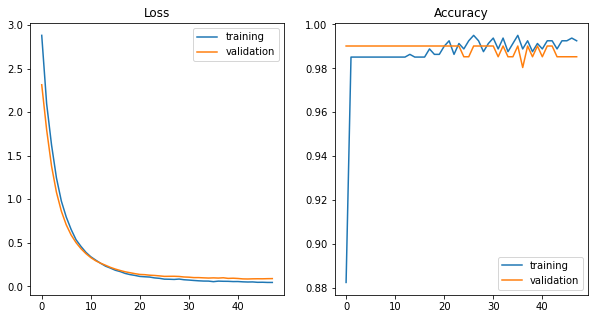

optimal threshold = 0.99
 TASK = BIN_PPARA
 No samples TRAIN = 991, No samples TEST =  244
 % actives TRAIN = 98.79, % actives TEST = 98.77
Model: "model_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_63 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dense_92 (Dense)             (None, 100)               102500    
_________________________________________________________________
dropout_92 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_93 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_93 (Dropout)         (None, 100)               0         
_________________________________________________________________
preds (Dense)                (None, 1)            

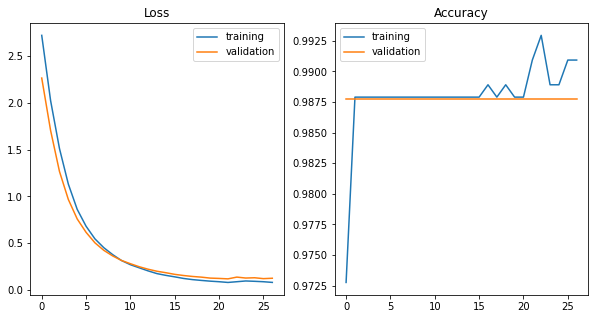

optimal threshold = 0.99
           Sensitivity  Specificity  Non-Error-Rate
AGO_PR           98.28        99.05           98.66
ANT_PR           93.55        93.91           93.73
BIN_PR           97.94        97.94           97.94
AGO_PXR          82.93        82.60           82.76
BIN_PXR          78.57        79.32           78.95
AGO_RXR          76.92        66.99           71.96
BIN_RXR          93.04        92.28           92.66
AGO_GR           96.69        97.43           97.06
ANT_GR           90.65        91.32           90.99
BIN_GR           97.46        97.32           97.39
AGO_AR           92.31        93.78           93.05
ANT_AR           92.55        91.73           92.14
BIN_AR           97.39        97.26           97.32
AGO_ERA          87.74        90.00           88.87
ANT_ERA          86.21        88.74           87.47
BIN_ERA          94.92        94.51           94.71
AGO_ERB          93.33        95.33           94.33
ANT_ERB          86.67        88.44    

In [48]:
start = time.time()
allsn, allsp, allner = [],[],[]
for i in range(len(tasks)):
    X_train_i = X_train[y_train[:,i]!=MASK_VALUE,:]
    y_train_i = y_train[y_train[:,i]!=MASK_VALUE,i]
    X_test_i = X_test[y_test[:,i]!=MASK_VALUE,:]
    y_test_i = y_test[y_test[:,i]!=MASK_VALUE,i]

    print(f" TASK = {tasks[i]}")
    print(f" No samples TRAIN = {len(X_train_i)}, No samples TEST =  {len(X_test_i)}")
    print(f" % actives TRAIN = {np.round((np.sum(y_train_i==1)/len(y_train_i))*100,2)}, % actives TEST = {np.round((np.sum(y_test_i==1)/len(y_test_i))*100,2)}")

    model = create_stl_model(X_train_i, Set_stl)
    
    n_x = X_train_i.shape[0]
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    history = model.fit(X_train_i, y_train_i, epochs=Set_stl.epochs, 
                        batch_size=int(Set_stl.batch_size*n_x/100),
                        callbacks=[es], verbose=0,
                        validation_data=(X_test_i, y_test_i))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.legend(["training", "validation"])
    ax1.set_title("Loss")
    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.legend(["training", "validation"])
    ax2.set_title("Accuracy")

    plt.show()
    
    y_pred_val = model.predict(X_test_i)
    y_pred_val = y_pred_val.flatten()
    thr = calc_optimal_thr(y_pred_val[:,np.newaxis], y_test_i[:,np.newaxis])
    print(f"optimal threshold = {thr[0]}")
    
    preds_i = (y_pred_val>thr[0]*np.ones(y_test_i.shape))*1
    sn, sp, ner = calc_class_param_mat(preds_i, np.array(y_test_i))
    allsn.append(sn)
    allsp.append(sp)
    allner.append(ner)
    
stl_res = pd.DataFrame([np.round(np.array(allsn)*100,2), np.round(np.array(allsp)*100,2), np.round(np.array(allner)*100,2)], 
                       columns = tasks, 
                       index = ['Sensitivity', 'Specificity', 'Non-Error-Rate']).T
    
end = time.time()
stl_total_time = np.round(end-start, 2)
stl_total_params = model.count_params()*len(tasks)
print(stl_res)
print(f"TOTAL TIME = {stl_total_time} seconds")

## 4. Multi task model <a name="mtl"></a>

### 4.1 Architecture <a name="mtl_arch"></a>

In [49]:
Set_mtl = Settings(data_train = data_train,
                   data_test = data_test,
                   labelX = [f"bit{i}" for i in range(1,1025)],
                   labelY = tasks,
                   tasks = tasks,
                   layers = [100,100],
                   act_fnc = 'relu',
                   epochs = 1000,
                   batch_size = 10,
                   lr = 0.001,
                   opt = 'adam',
                   drp = 0.25)

### 4.2 Model <a name="mtl_mod"></a>

In [50]:
def create_mtl_model(X_train, y_train, Set):
    optim = do_opt(Set.opt, Set.lr)
    n_y = y_train.shape[1]
    inp = Input(shape=(X_train.shape[1],))
    hid = inp
    
    for l in Set.layers:
        hid = Dense(l, activation=Set.act_fnc, kernel_regularizer=keras.regularizers.L2(0.01))(hid)
        hid = Dropout(Set.drp)(hid)
    
    outs = []
    for i in range(n_y):
        outs.append(Dense(1, activation='sigmoid', name = "preds_"+str(i))(hid))

    model = keras.Model(inputs=inp, outputs=outs)
    model.compile(loss=masked_loss_function, optimizer=optim, metrics=[masked_accuracy])
    model.summary()
    return model

Model: "model_63"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_64 (InputLayer)           [(None, 1024)]       0                                            
__________________________________________________________________________________________________
dense_94 (Dense)                (None, 100)          102500      input_64[0][0]                   
__________________________________________________________________________________________________
dropout_94 (Dropout)            (None, 100)          0           dense_94[0][0]                   
__________________________________________________________________________________________________
dense_95 (Dense)                (None, 100)          10100       dropout_94[0][0]                 
___________________________________________________________________________________________

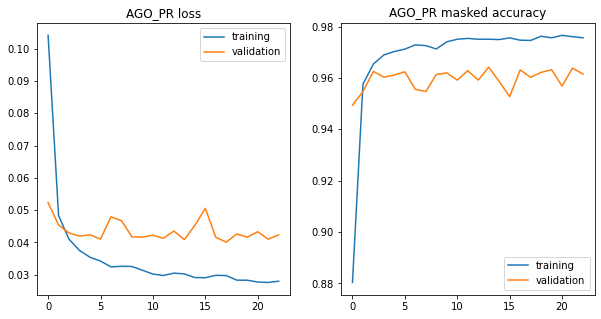

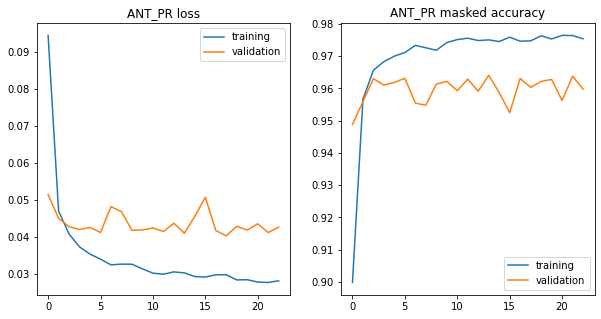

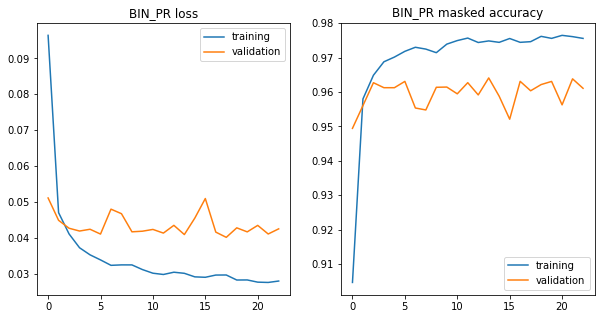

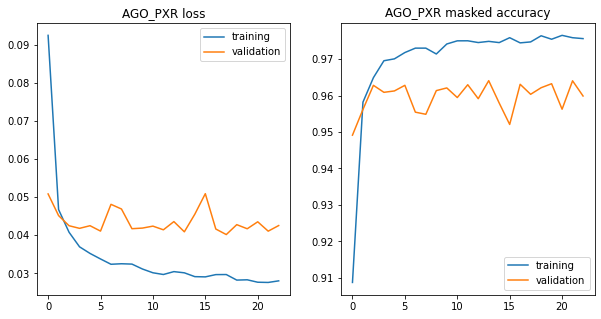

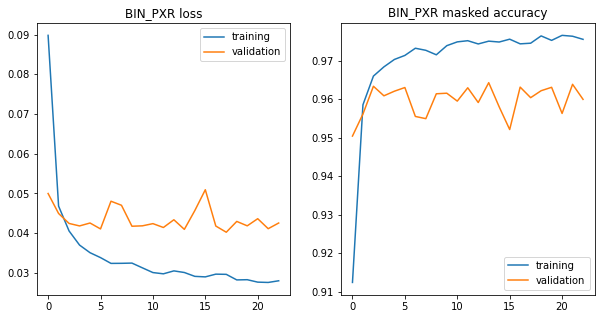

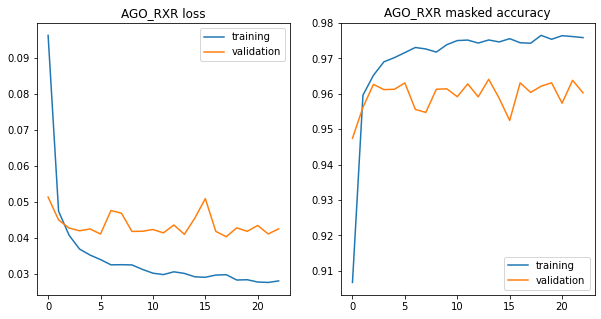

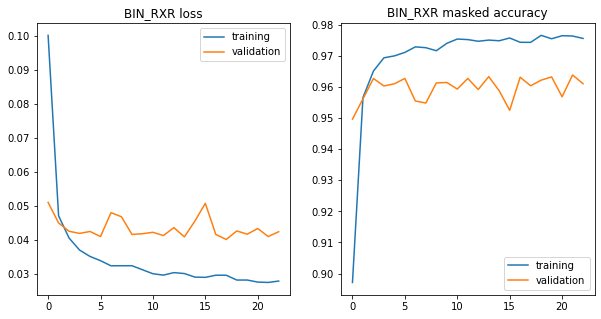

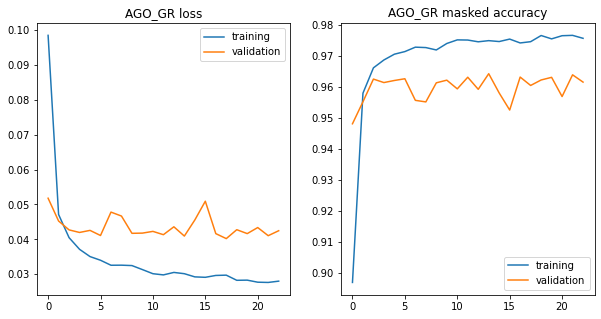

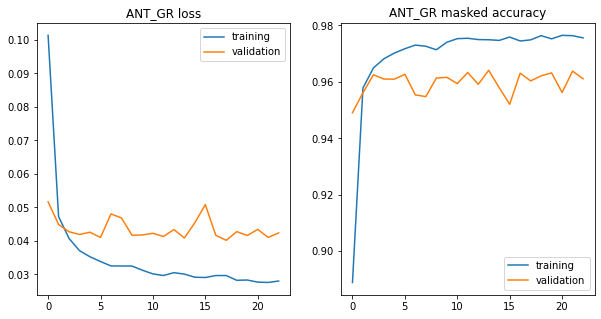

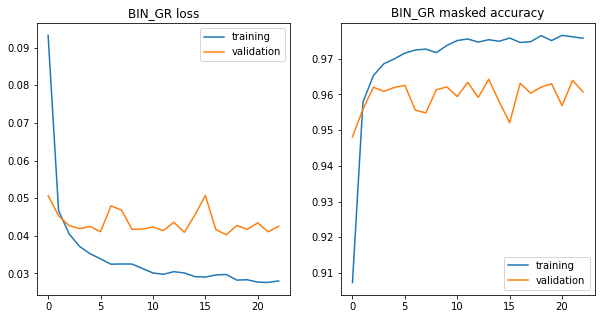

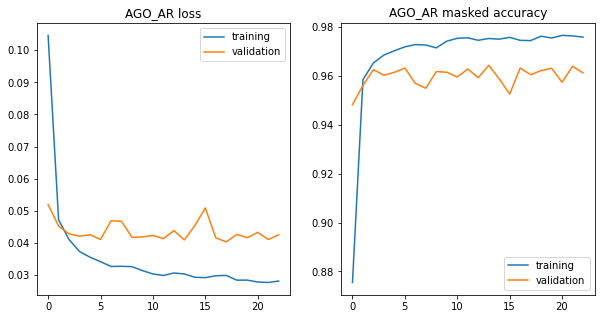

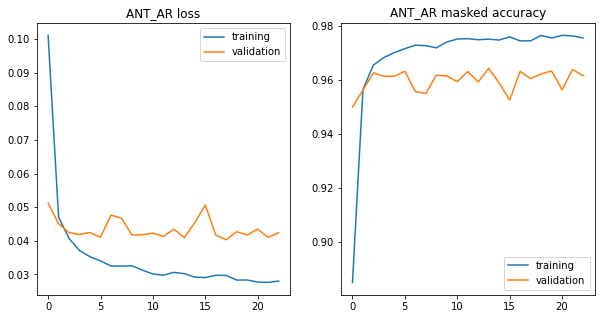

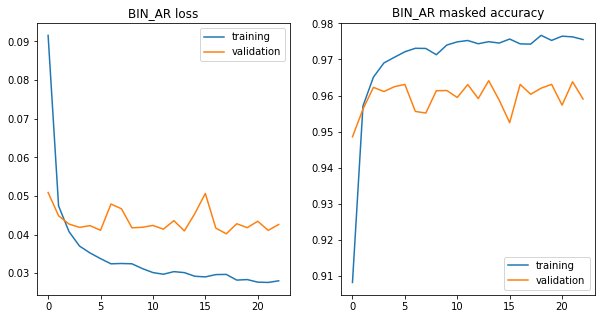

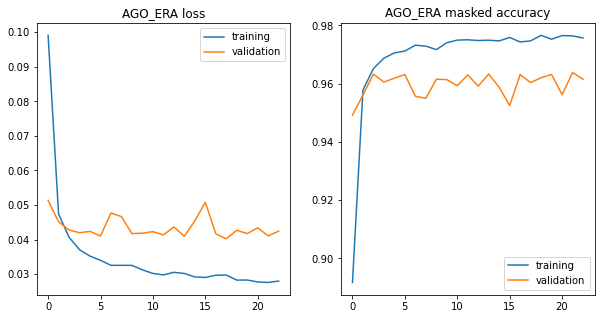

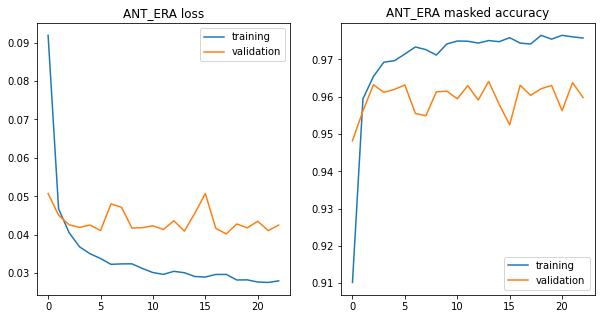

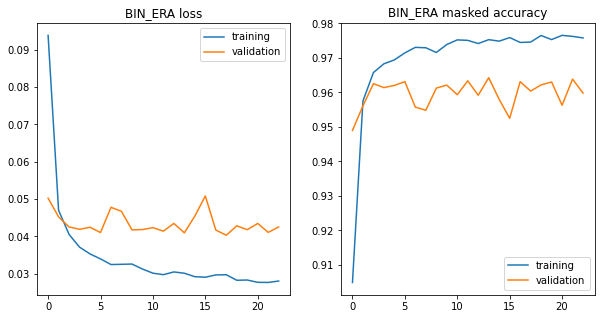

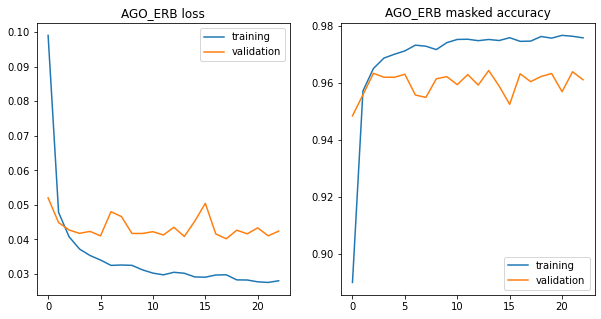

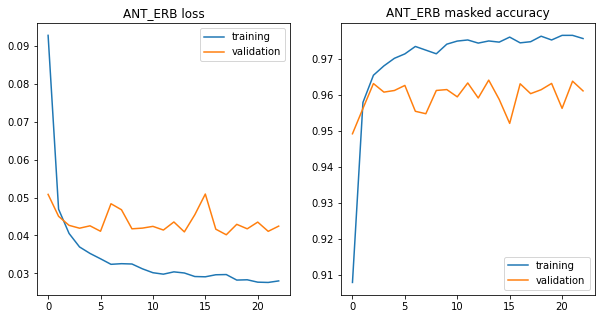

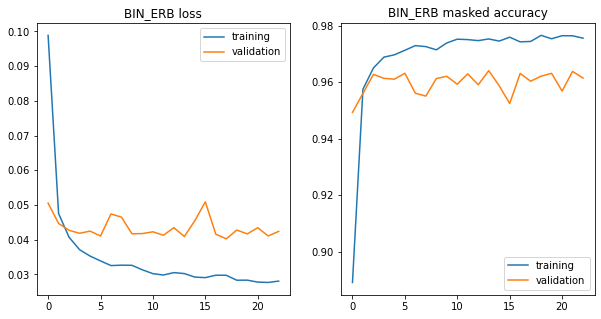

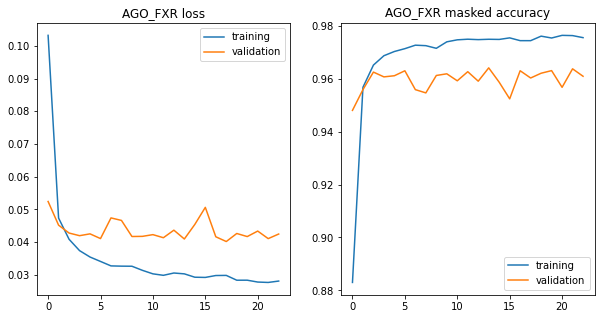

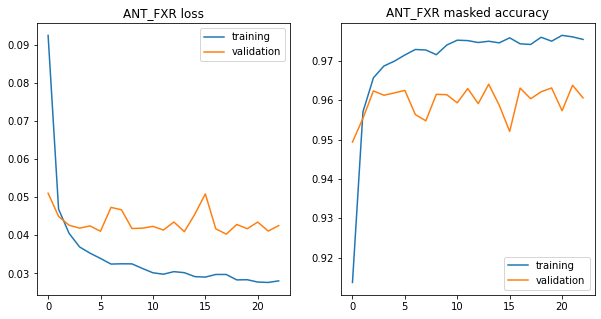

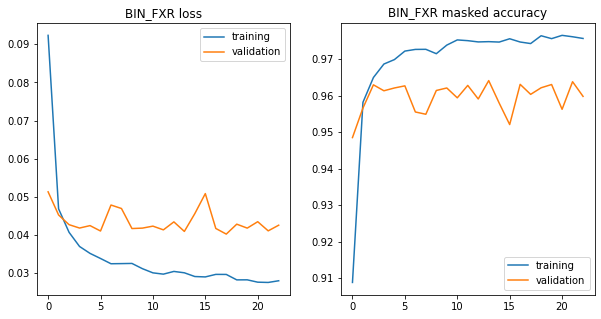

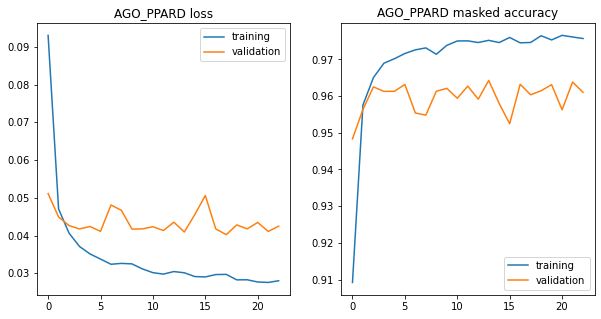

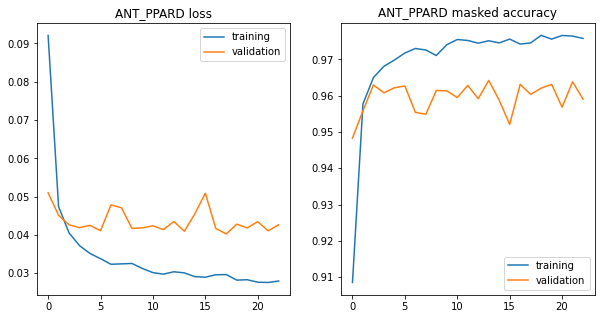

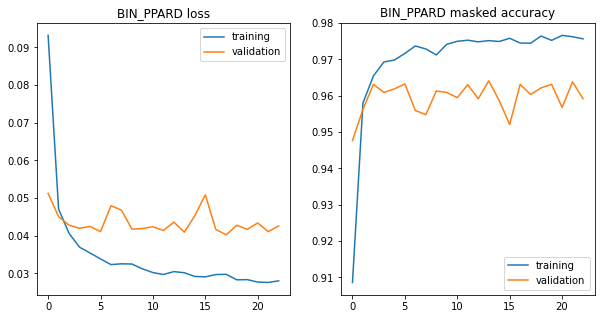

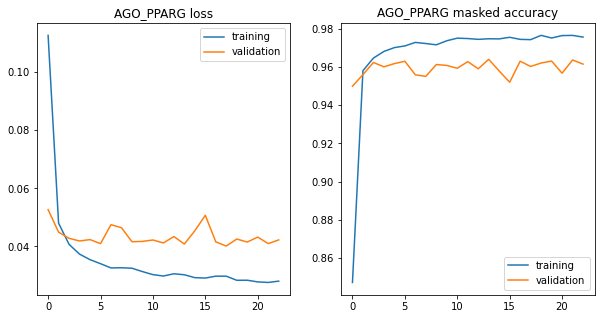

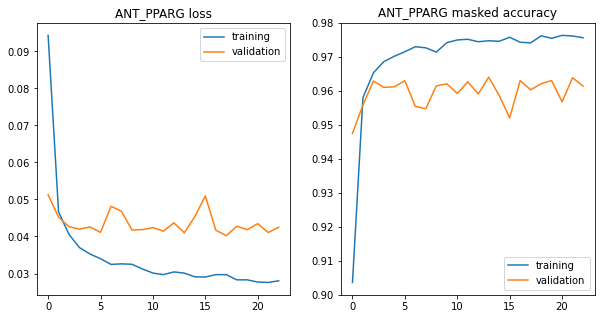

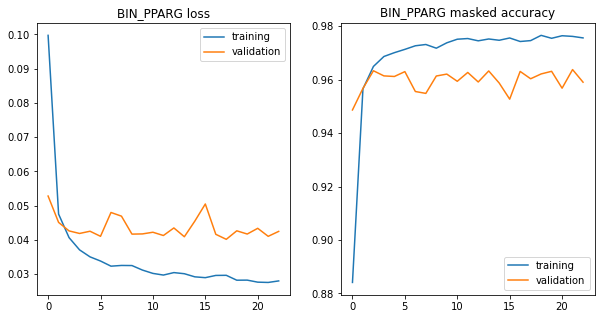

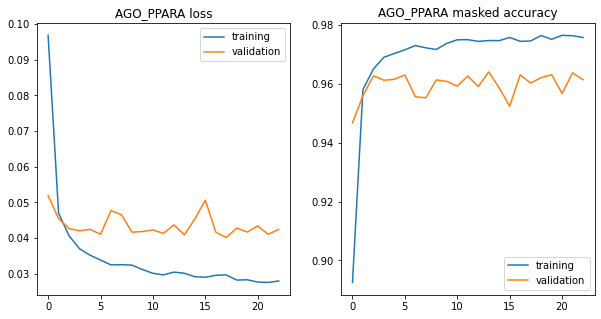

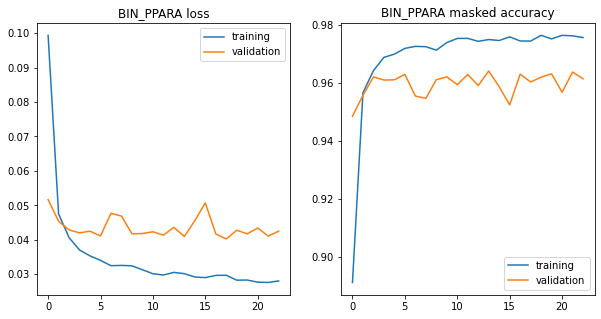

           Sensitivity  Specificity  Non-Error-Rate
AGO_PR           94.83        94.32           94.57
ANT_PR           92.90        93.12           93.01
BIN_PR           97.53        97.55           97.54
AGO_PXR          78.05        84.62           81.33
BIN_PXR          78.57        84.62           81.59
AGO_RXR          69.23        77.70           73.47
BIN_RXR          92.41        92.17           92.29
AGO_GR           95.36        95.51           95.44
ANT_GR           92.09        93.06           92.57
BIN_GR           96.33        96.46           96.39
AGO_AR           91.35        91.47           91.41
ANT_AR           90.06        89.71           89.88
BIN_AR           95.75        95.40           95.58
AGO_ERA          88.68        87.03           87.85
ANT_ERA          88.51        89.51           89.01
BIN_ERA          95.31        95.34           95.32
AGO_ERB          90.00        89.79           89.90
ANT_ERB          88.89        88.64           88.76
BIN_ERB     

In [51]:
start = time.time()

model = create_mtl_model(X_train, y_train, Set_mtl)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = model.fit(X_train, y_train, epochs=Set_mtl.epochs, 
                    batch_size=int(Set_mtl.batch_size*n_x/100), 
                    callbacks=[es], verbose=0,
                    validation_data=(X_test, y_test))

for t in range(30):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    ax1.plot(history.history[f'preds_{t}_loss'])
    ax1.plot(history.history[f'val_preds_{t}_loss'])
    ax1.legend(["training", "validation"])
    ax1.set_title(f"{tasks[t]} loss")
    ax2.plot(history.history[f'preds_{t}_masked_accuracy'])
    ax2.plot(history.history[f'val_preds_{t}_masked_accuracy'])
    ax2.legend(["training", "validation"])
    ax2.set_title(f"{tasks[t]} masked accuracy")

    plt.show()
    
y_pred_test = model.predict(X_test)   
y_pred_test = np.transpose(np.array(y_pred_test)[:,:,0])

thr_nrs = calc_optimal_thr(y_pred_test, y_test)

allsn, allsp, allner = [],[],[]
for t in np.arange(y_pred_test.shape[1]):
    y_pred_val_t = y_pred_test[y_test[:,t] != MASK_VALUE,t]
    y_val_t = y_test[y_test[:,t] != MASK_VALUE,t]
    preds_i = (y_pred_val_t>thr_nrs[t]*np.ones(y_pred_val_t.shape))*1
    sn, sp, ner = calc_class_param_mat(preds_i, np.array(y_val_t))
    allsn.append(sn)
    allsp.append(sp)
    allner.append(ner)

mtl_res = pd.DataFrame([np.round(np.array(allsn)*100,2), np.round(np.array(allsp)*100,2), np.round(np.array(allner)*100,2)], 
                       columns = tasks, 
                       index = ['Sensitivity', 'Specificity', 'Non-Error-Rate']).T

end = time.time()

mtl_total_time = np.round(end-start, 2)
mtl_total_params = model.count_params()
print(mtl_res)
print(f"TOTAL TIME = {mtl_total_time} seconds")

## 5. Comparison <a name="comp"></a>

In [52]:
#time, trainable params, performance

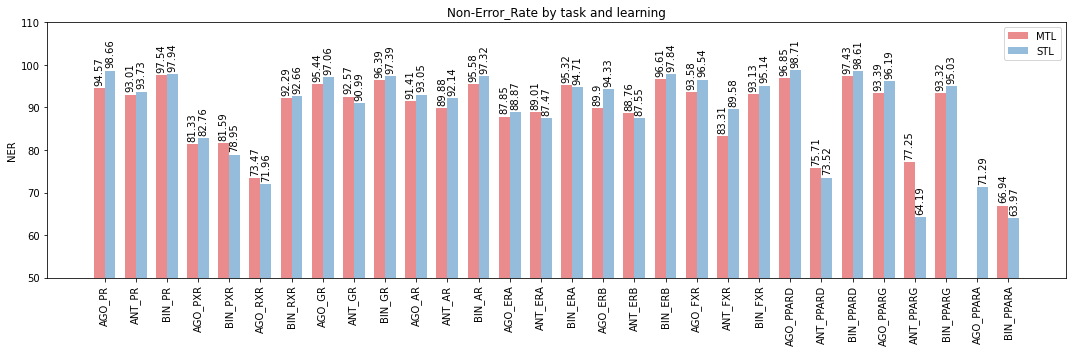

In [55]:
mtl_ner = mtl_res["Non-Error-Rate"].values
stl_ner = stl_res["Non-Error-Rate"].values

x = np.arange(len(tasks))  
width = 0.35 

fig, ax = plt.subplots(figsize = (15,5))
rects1 = ax.bar(x - width/2, mtl_ner, width, label='MTL', color= "#D7191C", alpha = 0.5)
rects2 = ax.bar(x + width/2, stl_ner, width, label='STL', color= "#2C7BB6", alpha = 0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('NER')
ax.set_title('Non-Error_Rate by task and learning')
ax.set_xticks(x)
ax.set_xticklabels(list(tasks), rotation = 90)
ax.set_ylim([50,110])
ax.legend()

ax.bar_label(rects1, padding=3, rotation = 90)
ax.bar_label(rects2, padding=3, rotation = 90)

fig.tight_layout()
plt.savefig(f'ex.svg')
plt.show()

In [54]:
pd.DataFrame({'total time':[mtl_total_time, stl_total_time], 
              'total trainable params':[mtl_total_params, stl_total_params]},
            index = ['MTL','STL'])

,total time,total trainable params
MTL,59.55,115630
STL,203.24,3381030
